In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import re

#Firstly, load the .json file to a DataFrame
with open('transaction-data-adhoc-analysis.json','r') as f:
    data = pd.read_json(f)
    
#Create a new DataFrame to store the customer names and the transaction dates; converting the transaction dates into DateTime and sort. 
#Created a transaction_count column to easily sum up the number of transaction each person did in a certain month
#Extracted the months and put into a new column to associate each transaction to a month
customer_transaction_df = pd.DataFrame().assign(customers=data['name'], transaction_date=data['transaction_date'])
customer_transaction_df = customer_transaction_df.assign(transaction_count=1)
customer_transaction_df['transaction_date'] = pd.to_datetime(customer_transaction_df['transaction_date'])
customer_transaction_df.sort_values(['transaction_date','customers'],inplace=True)
customer_transaction_df['month'] = customer_transaction_df['transaction_date'].dt.month

#Created a pivot table to store the total transaction each customer made per month
#Renamed the columns to remove the Multi-level Indices
cust_transaction_pivot = pd.pivot_table(customer_transaction_df, values = ['transaction_count'], columns = ['month'],index=['customers'],aggfunc=np.sum,fill_value=0)
cust_transaction_pivot.columns = customer_transaction_df['transaction_date'].dt.month.unique()
cust_transaction_pivot.reset_index(inplace=True)

#Created a function to check if a customer transacted in a month or no, regardless of the frequency
def did_transact(qty):
    if qty != 0:
        return True
    else:
        return False

#Created a new DataFrame to store the Boolean Values
cust_transaction_truth = pd.DataFrame()
for i in range(len(customer_transaction_df['transaction_date'].dt.month.unique())):
    cust_transaction_truth[i+1] = cust_transaction_pivot.apply(lambda x:did_transact(x[i+1]),axis=1)

#Created a new column on the same DataFrame to aggregate the Boolean values into a list
#This list of Boolean values will make it easier to compare values needed to check if a customer is a 'Repeater', 'Inactive', or 'Engaged'
cust_transaction_truth['aggregated_transactions'] = cust_transaction_truth.values.tolist()

#These functions will iterate through the list of Boolean values and check if a customer is a 'Repeater', 'Inactive', or 'Engaged'
def repeater(agg):
    repeater_list = []
    for i in range(len(agg)):
        if i == 0:
            repeater_list.append(0)
        elif agg[i-1] == False and agg[i] == True:
            repeater_list.append(0)
        elif agg[i-1] == False or agg[i] == False:
            repeater_list.append(0)
        elif agg[i-1] == True and agg[i] == True:
            repeater_list.append(1)
    return repeater_list

def inactive(agg):
    inactive_list = []
    for i in range(len(agg)):
        if i == 0:
            inactive_list.append(0)
        elif True in agg [:+1]:
            if agg[i]==False:
                inactive_list.append(1)
            else:
                inactive_list.append(0)
        else:
            inactive_list.append(0)
    return inactive_list

def engaged(agg):
    engaged_list = []
    for i in range(len(agg)):
        if True in agg[:i+1]:
            if len(agg[:i+1]) == 1:
                engaged_list.append(1)
            elif all(agg[:i+1])==True:
                engaged_list.append(1)
            else:
                engaged_list.append(0)
        else:
            engaged_list.append(0)
    return engaged_list

#Creates a new column to store the list created by the three functions
#The value 1 represents the presence of a customer who is a 'Repeater', 'Inactive, or 'Engaged', otherwise the value is 0
cust_transaction_truth['repeater_list'] = cust_transaction_truth.apply(lambda x:repeater(x['aggregated_transactions']),axis=1)
cust_transaction_truth['inactive_list'] = cust_transaction_truth.apply(lambda x:inactive(x['aggregated_transactions']),axis=1)
cust_transaction_truth['engaged_list'] = cust_transaction_truth.apply(lambda x:engaged(x['aggregated_transactions']),axis=1)

#Each status column (which contains a list) will be stored in a new DataFrame, separated into columns of months
repeater_df = pd.DataFrame(cust_transaction_truth['repeater_list'].to_list(), columns=customer_transaction_df['transaction_date'].dt.month.unique())
inactive_df = pd.DataFrame(cust_transaction_truth['inactive_list'].to_list(), columns=customer_transaction_df['transaction_date'].dt.month.unique())
engaged_df = pd.DataFrame(cust_transaction_truth['engaged_list'].to_list(), columns=customer_transaction_df['transaction_date'].dt.month.unique())

#Find the sum of each status using the .sum() function
repeater_per_month = repeater_df.sum(axis=0)
inactive_per_month = inactive_df.sum(axis=0)
engaged_per_month = engaged_df.sum(axis=0)

#Create a new DataFrame to store the consolidated values
loyalty_metric_df = pd.DataFrame(index=['Repeater','Inactive','Engaged'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#Inputs the sums into the new DataFrame
for i in range(len(customer_transaction_df['transaction_date'].dt.month.unique())):
    loyalty_metric_df.loc['Repeater',f'{months[i]}'] = repeater_per_month.iloc[i]
    loyalty_metric_df.loc['Inactive',f'{months[i]}'] = inactive_per_month.iloc[i]
    loyalty_metric_df.loc['Engaged',f'{months[i]}'] = engaged_per_month.iloc[i]
loyalty_metric_df

,Jan,Feb,Mar,Apr,May,Jun
Repeater,0.0,5172.0,5216.0,5154.0,5110.0,5193.0
Inactive,0.0,1416.0,1378.0,1437.0,1445.0,1393.0
Engaged,6588.0,5172.0,4126.0,3289.0,2667.0,2190.0


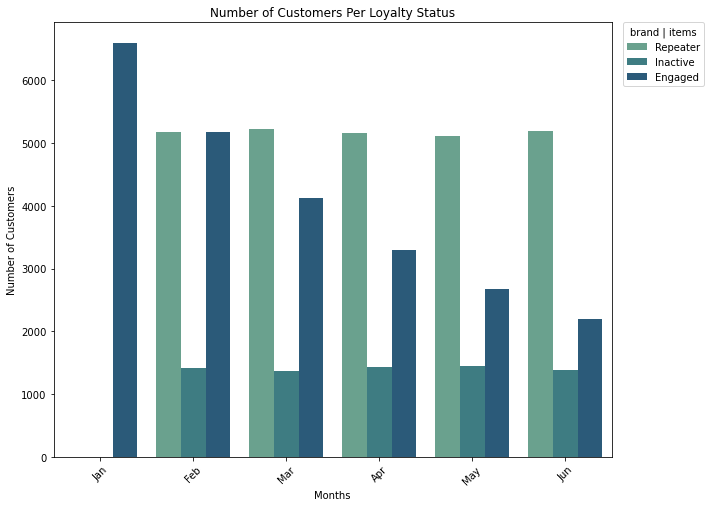

In [2]:
loyalty_metric_for_plot = pd.melt(loyalty_metric_df.reset_index(),id_vars='index',var_name='Months', value_name='Number of Customers')
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.title('Number of Customers Per Loyalty Status')
sns.barplot(x='Months', y='Number of Customers', hue='index', data=loyalty_metric_for_plot, palette='crest')
plt.legend(title='brand | items',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('loyalty_status.png', bbox_inches='tight')